# Demonstrating jointcal plate scale calculations


In [1]:
import itertools
import os.path
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

from lsst.afw.geom import SkyWcs
from lsst.afw import cameraGeom
import lsst.jointcal.cameraGeometry
import lsst.obs.hsc

## Read data

For this demo, we use the jointcal output files that are included for the tests, and create an HSC camera directly from obs_subaru. Because this is test data, it does not include a butler, so we read the files and create the camera directly.

If you have a butler repo with jointcal output, read in the WCSs you want with the `jointcal_wcs` dataset type, make a list out of them to pass to `cameraGeometry.CameraModel`, and a 1-1 matched list with the detector ids for each of those WCSs. You also need to get the camera object from the butler (`camera` dataset type).

In [2]:
# 49 is near the center of the focal plane
detector1 = 49
# 37 is on the west side of the focal plane
detector2 = 37
# 103 is on the NW edge of the focal plane and rotated 90 degrees
detector3 = 103
# 90 is on the NE corner of the focal plane
detector4 = 90

cameraPath = os.path.join(lsst.utils.getPackageDir("obs_subaru"), "hsc/camera")
cameraConfig = lsst.afw.cameraGeom.CameraConfig()
cameraConfig.load(os.path.join(cameraPath, "camera.py"))
camera = lsst.afw.cameraGeom.makeCameraFromPath(cameraConfig, cameraPath, lambda x: x,
                                                     lsst.obs.hsc.HscPupilFactory)
maxFocalPlaneRadius = camera.computeMaxFocalPlaneRadius()

path = "../tests/data/output/HSC-R/9615/"

wcsList = []
detectors = []
for detector, visit in itertools.product([detector1, detector2, detector3],
                                  [28976, 23924, 23900]):
        wcsList.append(SkyWcs.readFits(os.path.join(path, f"jointcal_wcs-{visit:07}-{detector:03}.fits")))
        detectors.append(detector)

In [3]:
model = lsst.jointcal.cameraGeometry.CameraModel(wcsList, detectors, camera)

In [4]:
model.computePixelScale()

## Make some plots

To see the differences between the curves and how they overlap with the standard deviation, you have to zoom in a lot. The pixel size delta plot shows how the radial and tangential pixel scales differ between the built-in camera model used by HSC and this fitted model from jointcal.

This notebook does not further investigate those differences, but there is likely is an altitude-dependent component to the HSC distortion model, either due to gravity loading flexure, or some other product of the ADC. This could be tested using visits with a wider range of zenith angles (including positive and negative angles).

In [5]:
# The pixel scale given by the built-in camera distortion model.
cameraField, cameraRadial, cameraTangential = model.computeCameraPixelScale()

<IPython.core.display.Javascript object>


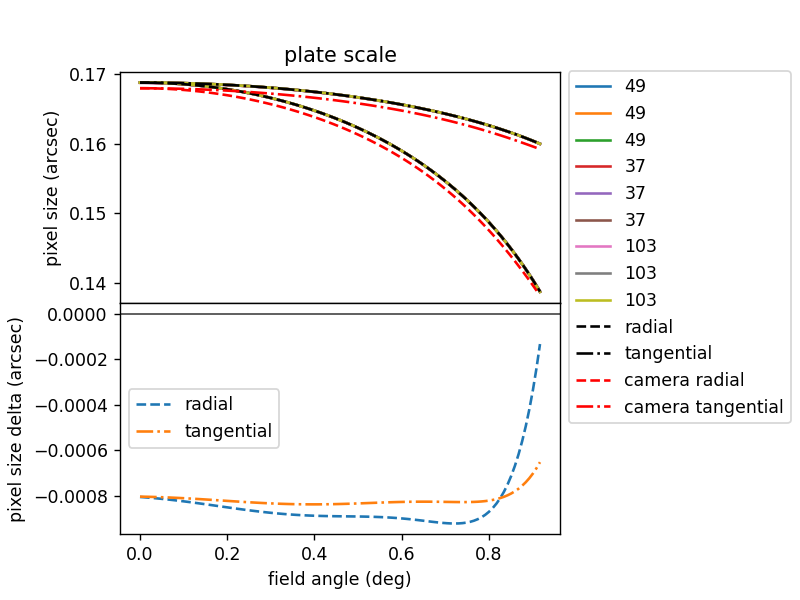

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.subplots_adjust(hspace=0, right=0.7, left=0.15)
ax1.set_xticklabels([])

# plot the values themselves
for angle, radial, tangential, detector in zip(model.fieldAngles, model.radialScales,
                                               model.tangentialScales, detectors):
    line, = ax1.plot(angle, radial, label=detector)
    ax1.plot(angle, tangential, color=line.get_color())

ax1.plot(model.fieldAngle, model.radialScale, '--', lw=1.5, color="black", label="radial")
ax1.fill_between(model.fieldAngle, model.radialScale-model.radialScaleStd,
                 model.radialScale+model.radialScaleStd,
                alpha=0.4, color="grey")

ax1.plot(model.fieldAngle, model.tangentialScale, '-.', lw=1.5, color="black", label="tangential")
ax1.fill_between(model.fieldAngle, model.tangentialScale-model.tangentialScaleStd,
                 model.tangentialScale+model.tangentialScaleStd,
                alpha=0.4, color="grey")

ax1.plot(cameraField, cameraRadial, '--', color='red', label='camera radial')
ax1.plot(cameraField, cameraTangential, '-.', color='red', label='camera tangential')

# ax1.set_xlabel("field angle (deg)")
ax1.set_ylabel("pixel size (arcsec)")
ax1.set_title("plate scale")
ax1.legend(bbox_to_anchor=(1,1.04), loc="upper left")

# differences
ax2.axhline(0, color="black", lw=1, alpha=0.7)
ax2.plot(cameraField, cameraRadial-model.radialScale, ls='--', label="radial")
ax2.plot(cameraField, cameraTangential-model.tangentialScale, ls='-.', label="tangential")
ax2.set_xlabel("field angle (deg)")
ax2.set_ylabel("pixel size delta (arcsec)")
ax2.legend()